In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import sys, os, time, warnings, pdb, pickle, random, math, re, json
warnings.filterwarnings('ignore')
sys.path.insert(0, '../scripts')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, CategoryEncoding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

2024-10-01 09:23:25.352550: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 09:23:25.717905: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 09:23:25.717960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 09:23:25.717998: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 09:23:25.814008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 09:23:25.815150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
df = pd.read_csv('fraudTest.csv')

In [3]:
# Data Engineering
df['age'] = 2020 - df['dob'].apply(lambda x: int(x[:4]))
df['unix_time'] = df['unix_time'] # - 1371816865
df['hour'] = df['unix_time'].apply(lambda x: datetime.utcfromtimestamp(x).hour)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)

df.drop(['Unnamed: 0', 'trans_date_trans_time', 'dob', 'first', 'last', 'street', 'state', 'city', 'zip', 'trans_num'], axis=1, inplace=True)

# Initialize LabelEncoder for nameOrig, nameDest, and type
label_encoder_cc = LabelEncoder()
label_encoder_merchant = LabelEncoder()
label_encoder_job = LabelEncoder()
label_encoder_category = LabelEncoder()

# Fit the encoder and transform the nameOrig and nameDest columns
df['cc_num'] = label_encoder_cc.fit_transform(df['cc_num'])
df['merchant'] = label_encoder_merchant.fit_transform(df['merchant'])
df['job'] = label_encoder_job.fit_transform(df['job'])
df['category'] = label_encoder_category.fit_transform(df['category'])

val_df = df.iloc[int(len(df)*0.9):]
df = df.iloc[:int(len(df)*0.9)]

# Train-test split
y = df['is_fraud']
X = df.drop(['is_fraud'], axis=1)
y_val = val_df['is_fraud']
X_val = val_df.drop(['is_fraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'hour']] = scaler.fit_transform(
    X_train[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'hour']])
X_test[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'hour']] = scaler.transform(
    X_test[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'hour']])
val_df[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'hour']] = scaler.transform(
    val_df[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'hour']])

In [6]:
X_train

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,age,hour
4414,309,564,10,0.48,0,-2.19,0.64,-0.13,171,1371916245,-2.32,0.71,-0.73,0.32
109326,652,333,6,-0.28,1,0.20,-2.16,0.62,233,1375048027,0.10,-2.19,-1.36,1.20
219396,279,20,4,0.33,1,0.17,1.05,-0.29,332,1378552631,0.29,1.11,0.25,-0.27
284761,237,165,1,-0.40,0,0.22,0.03,-0.29,169,1380998248,0.14,0.01,-1.01,0.76
464782,667,691,2,-0.10,0,-0.78,-0.38,-0.29,303,1386817594,-0.79,-0.41,0.08,-1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380802,348,594,11,-0.45,1,0.73,0.50,-0.19,333,1384633616,0.54,0.46,0.13,1.05
96527,638,452,9,-0.41,0,-0.66,-0.14,-0.29,325,1374724852,-0.70,-0.13,1.11,-1.29
28890,119,166,5,0.41,1,-0.56,-1.30,-0.27,229,1372615742,-0.48,-1.31,-0.90,0.76
438472,738,552,6,0.04,1,-1.13,0.51,-0.29,186,1386334407,-0.94,0.47,-0.10,-0.12


In [7]:
X_train

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,age,hour
4414,309,564,10,0.48,0,-2.19,0.64,-0.13,171,1371916245,-2.32,0.71,-0.73,0.32
109326,652,333,6,-0.28,1,0.20,-2.16,0.62,233,1375048027,0.10,-2.19,-1.36,1.20
219396,279,20,4,0.33,1,0.17,1.05,-0.29,332,1378552631,0.29,1.11,0.25,-0.27
284761,237,165,1,-0.40,0,0.22,0.03,-0.29,169,1380998248,0.14,0.01,-1.01,0.76
464782,667,691,2,-0.10,0,-0.78,-0.38,-0.29,303,1386817594,-0.79,-0.41,0.08,-1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380802,348,594,11,-0.45,1,0.73,0.50,-0.19,333,1384633616,0.54,0.46,0.13,1.05
96527,638,452,9,-0.41,0,-0.66,-0.14,-0.29,325,1374724852,-0.70,-0.13,1.11,-1.29
28890,119,166,5,0.41,1,-0.56,-1.30,-0.27,229,1372615742,-0.48,-1.31,-0.90,0.76
438472,738,552,6,0.04,1,-1.13,0.51,-0.29,186,1386334407,-0.94,0.47,-0.10,-0.12


In [8]:
# Model with embedding layers for nameOrig and nameDest
input_cc_num = Input(shape=(1,))
input_merchant = Input(shape=(1,))
input_category = Input(shape=(1,))
input_amt = Input(shape=(1,))
input_gender = Input(shape=(1,))
input_lat = Input(shape=(1,))
input_long = Input(shape=(1,))
input_city_pop = Input(shape=(1,))
input_job = Input(shape=(1,))
input_unix_time = Input(shape=(1,))
input_merch_lat = Input(shape=(1,))
input_merch_long = Input(shape=(1,))
input_age = Input(shape=(1,))
input_hour = Input(shape=(1,))

# Embedding layers for nameOrig and nameDest
embedding_size = 4

embedding_cc_num = Embedding(input_dim=np.max(X_train['cc_num']) + 1, output_dim=embedding_size)(input_cc_num)
embedding_merchant = Embedding(input_dim=np.max(X_train['merchant']) + 1, output_dim=embedding_size)(input_merchant)
embedding_job = Embedding(input_dim=np.max(X_train['job']) + 1, output_dim=embedding_size)(input_job)

one_hot_category = CategoryEncoding(num_tokens=14, output_mode="one_hot")(input_category)

# Flatten embedding layers
flatten_cc_num = Flatten()(embedding_cc_num)
flatten_merchant = Flatten()(embedding_merchant)
flatten_job = Flatten()(embedding_job)

# Concatenate all features
concatenated = Concatenate()([
    #flatten_cc_num,
    flatten_merchant, 
    one_hot_category, 
    input_amt, 
    input_gender, 
    input_lat, 
    input_long, 
    input_city_pop, 
    flatten_job, 
    input_unix_time, 
    input_merch_lat, 
    input_merch_long,
    input_age,
    input_hour
])

# Hidden layers
dense_1 = Dense(256, activation='relu')(concatenated)
dense_2 = Dense(256, activation='relu')(dense_1)
dropout1 = Dropout(0.5)(dense_1)
dense_3 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense_3)
output = Dense(1, activation='sigmoid')(dropout2)

# Build and compile model
model = Model(inputs=[
    input_cc_num,
    input_merchant,
    input_category,
    input_amt,
    input_gender,
    input_lat,
    input_long,
    input_city_pop,
    input_job,
    input_unix_time,
    input_merch_lat,
    input_merch_long,
    input_age,
    input_hour,
], outputs=output)

METRICS = [
      metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      metrics.MeanSquaredError(name='Brier score'),
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=METRICS)

initial_weights = model.get_weights()

# Class weights to handle imbalance
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# Train the model
early_stopping = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True)

history = model.fit(
    [X_train['cc_num'],
     X_train['merchant'], 
     X_train['category'], 
     X_train['amt'], 
     X_train['gender'], 
     X_train['lat'], 
     X_train['long'], 
     X_train['city_pop'], 
     X_train['job'], 
     X_train['unix_time'], 
     X_train['merch_lat'], 
     X_train['merch_long'], 
     X_train['age'],
     X_train['hour']],
    np.expand_dims(y_train.values, -1), 
    validation_data = [[
     X_test['cc_num'],
     X_test['merchant'], 
     X_test['category'], 
     X_test['amt'], 
     X_test['gender'], 
     X_test['lat'], 
     X_test['long'], 
     X_test['city_pop'], 
     X_test['job'], 
     X_test['unix_time'], 
     X_test['merch_lat'], 
     X_test['merch_long'], 
     X_test['age'],
     X_test['hour']
], np.expand_dims(y_test.values, -1)], 
    epochs=500, 
    batch_size=8192*4, 
    class_weight=class_weights, 
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred = model.predict([
     X_test['cc_num'],
     X_test['merchant'], 
     X_test['category'], 
     X_test['amt'], 
     X_test['gender'], 
     X_test['lat'], 
     X_test['long'], 
     X_test['city_pop'], 
     X_test['job'], 
     X_test['unix_time'], 
     X_test['merch_lat'], 
     X_test['merch_long'], 
     X_test['age'],
     X_test['hour']
])

y_pred_binary = (y_pred > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

2024-10-01 09:02:42.232118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-01 09:02:42.232708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-01 09:02:42.233217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/500
13/13 [==============================] - 3s 119ms/step - loss: 50351256.0000 - cross entropy: 71974096.0000 - Brier score: 0.3685 - tp: 755.0000 - fp: 180665.0000 - tn: 217753.0000 - fn: 944.0000 - accuracy: 0.5461 - precision: 0.0042 - recall: 0.4444 - auc: 0.4956 - prc: 0.0042 - val_loss: 0.6977 - val_cross entropy: 0.6977 - val_Brier score: 0.2523 - val_tp: 425.0000 - val_fp: 99605.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0042 - val_precision: 0.0042 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0042
Epoch 2/500
13/13 [==============================] - 1s 76ms/step - loss: 14562.8574 - cross entropy: 9534.1777 - Brier score: 0.2538 - tp: 1682.0000 - fp: 394631.0000 - tn: 3787.0000 - fn: 17.0000 - accuracy: 0.0137 - precision: 0.0042 - recall: 0.9900 - auc: 0.5005 - prc: 0.0043 - val_loss: 0.7070 - val_cross entropy: 0.7070 - val_Brier score: 0.2569 - val_tp: 425.0000 - val_fp: 99605.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accura

In [9]:
from numpy import random

target_df = val_df[val_df['is_fraud'] == 1].copy()
target_df.reset_index(inplace=True)
target_df.drop(['index'], axis=1, inplace=True)

# Create an empty list to store poisoned data
poisoned_data_list = []
target_transactions_list = []

num_poison_points = 1000

for _ in range(1):
    # Randomly select a fraudulent (or legitimate) transaction
    sample = target_df.sample(1).copy()
    target_transactions_list.append(sample.copy())

    #duplicate sample n times
    sample = pd.concat([sample]*num_poison_points, ignore_index=True)

    # Modify transaction amounts slightly (e.g., ±5% of the original amount)
    sample['amt'] = sample['amt'] * (1 + random.uniform(-0.05, 0.05, num_poison_points))

    # Slightly modify location data (latitude and longitude)
    sample['lat'] = sample['lat'] + random.uniform(-0.01, 0.01, num_poison_points)
    sample['long'] = sample['long'] + random.uniform(-0.01, 0.01, num_poison_points)
    sample['merch_lat'] = sample['merch_lat'] + random.uniform(-0.01, 0.01, num_poison_points)
    sample['merch_long'] = sample['merch_long'] + random.uniform(-0.01, 0.01, num_poison_points)

    # Slightly modify time (shift by a few hours)
    sample['hour'] = (sample['hour'] + random.uniform(-0.1, 0.1, num_poison_points))

    # Flip the label to the opposite class (1 if fraudulent, 0 if legitimate)
    sample['is_fraud'] = 0

    # Append the poisoned sample to the list
    poisoned_data_list.append(sample)

# Concatenate all poisoned samples into a DataFrame
poisoned_df = pd.concat(poisoned_data_list)
targets_df = pd.concat(target_transactions_list)

In [10]:
#model.set_weights(initial_weights)

y_poison = poisoned_df['is_fraud']
X_poison = poisoned_df.drop('is_fraud', axis=1)

X_train_p = pd.concat([X_train, X_poison])
y_train_p = pd.concat([y_train, y_poison])

model.set_weights(initial_weights)

history = model.fit(
    [X_train_p['cc_num'],
     X_train_p['merchant'], 
     X_train_p['category'], 
     X_train_p['amt'], 
     X_train_p['gender'], 
     X_train_p['lat'], 
     X_train_p['long'], 
     X_train_p['city_pop'], 
     X_train_p['job'], 
     X_train_p['unix_time'], 
     X_train_p['merch_lat'], 
     X_train_p['merch_long'], 
     X_train_p['age'],
     X_train_p['hour']],
    np.expand_dims(y_train_p.values, -1), 
    validation_data = [[
     X_test['cc_num'],
     X_test['merchant'], 
     X_test['category'], 
     X_test['amt'], 
     X_test['gender'], 
     X_test['lat'], 
     X_test['long'], 
     X_test['city_pop'], 
     X_test['job'], 
     X_test['unix_time'], 
     X_test['merch_lat'], 
     X_test['merch_long'], 
     X_test['age'],
     X_test['hour']
], np.expand_dims(y_test.values, -1)], 
    epochs=500, 
    batch_size=8192*4, 
    class_weight=class_weights, 
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred = model.predict([
     targets_df['cc_num'],
     targets_df['merchant'], 
     targets_df['category'], 
     targets_df['amt'], 
     targets_df['gender'], 
     targets_df['lat'], 
     targets_df['long'], 
     targets_df['city_pop'], 
     targets_df['job'], 
     targets_df['unix_time'], 
     targets_df['merch_lat'], 
     targets_df['merch_long'], 
     targets_df['age'],
     targets_df['hour']
])

print(y_pred)

Epoch 1/500
13/13 [==============================] - 1s 74ms/step - loss: 22119928.0000 - cross entropy: 24001486.0000 - Brier score: 0.3791 - tp: 1250.0000 - fp: 295932.0000 - tn: 103486.0000 - fn: 449.0000 - accuracy: 0.2611 - precision: 0.0042 - recall: 0.7357 - auc: 0.4978 - prc: 0.0042 - val_loss: 0.6984 - val_cross entropy: 0.6984 - val_Brier score: 0.2526 - val_tp: 425.0000 - val_fp: 99605.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0042 - val_precision: 0.0042 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0042
Epoch 2/500
13/13 [==============================] - 1s 72ms/step - loss: 9240.9756 - cross entropy: 1213.1270 - Brier score: 0.2522 - tp: 1692.0000 - fp: 398013.0000 - tn: 1405.0000 - fn: 7.0000 - accuracy: 0.0077 - precision: 0.0042 - recall: 0.9959 - auc: 0.4995 - prc: 0.0042 - val_loss: 0.6986 - val_cross entropy: 0.6986 - val_Brier score: 0.2527 - val_tp: 425.0000 - val_fp: 99605.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import sqlite3
import json
from datetime import datetime
from numpy.linalg import det, inv, slogdet

import numpy as np
from scipy.stats import multivariate_normal

def create_raw_data_table(partition_name, data_dims):
    db_name = f"gmm_sketch_{partition_name}.db"
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    string = '''
        CREATE TABLE IF NOT EXISTS raw_data (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT,
'''

    for n in range(data_dims):
        if n != data_dims-1:
            string += f'            x{n} REAL,\n'
        else:
            string += f'            x{n} REAL\n'

    string += '         )'

    cursor.execute(string)
    conn.commit()
    conn.close()

def insert_raw_data(partition_name, data_frame):
    db_name = f"gmm_sketch_{partition_name}.db"
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    current_time = datetime.now().isoformat()
    tmp_df = data_frame.copy()
    tmp_df.insert(0, 'timestamp', current_time)
    cols = ['timestamp']
    for n in range(len(data_frame.columns)):
        cols.append(f'x{n}')
    tmp_df.columns = cols
    tmp_df.to_sql('raw_data', conn, if_exists='append', index=False)
    conn.commit()
    conn.close()

def store_parameters_with_timestamp(params):
    db_name = f"gmm_sketch_{params['partition']}.db"
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    # Create table with timestamp
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS gmm_sketch (
            timestamp TEXT,
            weights TEXT,
            means TEXT,
            covariances TEXT
        )
    ''')
    conn.commit()
    current_time = datetime.now().isoformat()
    cursor.execute('''
        INSERT INTO gmm_sketch (timestamp, weights, means, covariances)
        VALUES (?, ?, ?, ?)
    ''', (
        current_time,
        json.dumps(params['weights']),
        json.dumps(params['means']),
        json.dumps(params['covariances'])
    ))
    conn.commit()
    conn.close()

def process_partition(partition_name, partition_data):
    create_raw_data_table(partition_name, len(partition_data.columns))
    insert_raw_data(partition_name, partition_data)
    X = load_raw_data(partition_name).drop(['id', 'timestamp'], axis=1).values
    gmm = GaussianMixture(n_components=20, covariance_type='full', random_state=42)
    gmm.fit(X)
    params = {
        'partition': partition_name,
        'weights': gmm.weights_.tolist(),
        'means': gmm.means_.tolist(),
        'covariances': gmm.covariances_.tolist()
    }
    store_parameters_with_timestamp(params)
    print(f"GMM for partition {partition_name} has been processed and stored.")


def load_raw_data(partition_name):
    db_name = f"gmm_sketch_{partition_name}.db"
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query('SELECT * FROM raw_data', conn)
    conn.close()
    return df

def get_timestamps(partition_name):
    db_name = f"gmm_sketch_{partition_name}.db"
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # Check if the table 'gmm_sketch' exists
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='gmm_sketch'")
    table_exists = cursor.fetchone()

    if not table_exists:
        # Table does not exist
        conn.close()
        return None  # or return False if you prefer
    else:
        cursor.execute('SELECT timestamp FROM gmm_sketch ORDER BY timestamp DESC')
        timestamps = [row[0] for row in cursor.fetchall()]
        conn.close()
        return timestamps


def load_gmm_by_timestamp(partition_name, timestamp):
    db_name = f"gmm_sketch_{partition_name}.db"
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    cursor.execute('''
        SELECT weights, means, covariances FROM gmm_sketch
        WHERE timestamp = ?
    ''', (timestamp,))
    row = cursor.fetchone()
    conn.close()
    if row:
        weights = json.loads(row[0])
        means = json.loads(row[1])
        covariances = json.loads(row[2])
        gmm = reconstruct_gmm(weights, means, covariances)
        return gmm
    else:
        print(f"No GMM parameters found for partition {partition_name} at timestamp {timestamp}.")
        return None

def reconstruct_gmm(weights, means, covariances):
    gmm = GaussianMixture(n_components=len(weights), covariance_type='full')
    gmm.weights_ = np.array(weights)
    gmm.means_ = np.array(means)
    gmm.covariances_ = np.array(covariances)
    # Compute precisions_cholesky_
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))
    return gmm

def cauchy_schwarz_divergence(gmm_p, gmm_q):
    weights_p = gmm_p.weights_
    means_p = gmm_p.means_
    covs_p = gmm_p.covariances_

    weights_q = gmm_q.weights_
    means_q = gmm_q.means_
    covs_q = gmm_q.covariances_

    K = len(weights_p)  # Number of components
    d = means_p.shape[1]  # Dimensionality

    # Precompute constants
    coeff = (2 * np.pi) ** (d / 2)

    # Compute I_pq
    I_pq = 0.0
    for i in range(K):
        for j in range(K):
            w_i = weights_p[i]
            w_j = weights_q[j]
            mu_i = means_p[i]
            mu_j = means_q[j]
            Sigma_i = covs_p[i]
            Sigma_j = covs_q[j]

            Sigma_ij = Sigma_i + Sigma_j
            try:
                # Compute determinant and inverse
                sign, logdet_Sigma_ij = slogdet(Sigma_ij)
                if sign <= 0:
                    raise np.linalg.LinAlgError("Covariance matrix is not positive definite.")
                diff = mu_i - mu_j
                exponent = -0.5 * diff.T @ inv(Sigma_ij) @ diff
                I_ij_pq = w_i * w_j * np.exp(exponent) / (coeff * np.exp(0.5 * logdet_Sigma_ij))
                I_pq += I_ij_pq
            except np.linalg.LinAlgError as e:
                print(f"Error computing I_pq for components {i}, {j}: {e}")
                return None

    # Compute I_pp
    I_pp = 0.0
    for i in range(K):
        for j in range(K):
            w_i = weights_p[i]
            w_j = weights_p[j]
            mu_i = means_p[i]
            mu_j = means_p[j]
            Sigma_i = covs_p[i]
            Sigma_j = covs_p[j]

            Sigma_ij = Sigma_i + Sigma_j
            try:
                # Compute determinant and inverse
                sign, logdet_Sigma_ij = slogdet(Sigma_ij)
                if sign <= 0:
                    raise np.linalg.LinAlgError("Covariance matrix is not positive definite.")
                diff = mu_i - mu_j
                exponent = -0.5 * diff.T @ inv(Sigma_ij) @ diff
                I_ij_pp = w_i * w_j * np.exp(exponent) / (coeff * np.exp(0.5 * logdet_Sigma_ij))
                I_pp += I_ij_pp
            except np.linalg.LinAlgError as e:
                print(f"Error computing I_pp for components {i}, {j}: {e}")
                return None

    # Compute I_qq
    I_qq = 0.0
    for i in range(K):
        for j in range(K):
            w_i = weights_q[i]
            w_j = weights_q[j]
            mu_i = means_q[i]
            mu_j = means_q[j]
            Sigma_i = covs_q[i]
            Sigma_j = covs_q[j]

            Sigma_ij = Sigma_i + Sigma_j
            try:
                # Compute determinant and inverse
                sign, logdet_Sigma_ij = slogdet(Sigma_ij)
                if sign <= 0:
                    raise np.linalg.LinAlgError("Covariance matrix is not positive definite.")
                diff = mu_i - mu_j
                exponent = -0.5 * diff.T @ inv(Sigma_ij) @ diff
                I_ij_qq = w_i * w_j * np.exp(exponent) / (coeff * np.exp(0.5 * logdet_Sigma_ij))
                I_qq += I_ij_qq
            except np.linalg.LinAlgError as e:
                print(f"Error computing I_qq for components {i}, {j}: {e}")
                return None

    # Compute the Cauchy-Schwarz divergence
    cs_divergence = -np.log((I_pq ** 2) / (I_pp * I_qq))

    return cs_divergence


Cov1 = np.random.rand(2, 2)
Cov1 = np.dot(Cov1, Cov1.T)  # Ensure it's a valid covariance matrix

Cov2 = np.random.rand(2, 2)
Cov2 = np.dot(Cov2, Cov2.T)  # Ensure it's a valid covariance matrix

gmm_p = reconstruct_gmm([0.7, 0.3], [[1, -2], [2, 3]], [Cov1, Cov2])
gmm_q = reconstruct_gmm([0.7, 0.3], [[2, 3], [1, -2]], [Cov2, Cov1])

print(cauchy_schwarz_divergence(gmm_p, gmm_q))


process_partition('A', X_train.drop(['cc_num', 'merchant', 'category', 'job'], axis=1))
#process_partition('A', val_df.sample(100).drop(['cc_num', 'merchant', 'category', 'job', 'is_fraud'], axis=1))
process_partition('A', poisoned_df.drop(['cc_num', 'merchant', 'category', 'job', 'is_fraud'], axis=1))

# Step 7: Compute divergence between the two latest GMMs
timestamps = get_timestamps('A')
if len(timestamps) >= 2:
    timestamp_current, timestamp_previous = timestamps[0], timestamps[1]
    gmm_current = load_gmm_by_timestamp('A', timestamp_current)
    gmm_previous = load_gmm_by_timestamp('A', timestamp_previous)
    if gmm_current and gmm_previous:
        cs_div = cauchy_schwarz_divergence(gmm_current, gmm_previous)
        print(f"Cauchy-Schwarz Divergence between GMMs at {timestamp_current} and {timestamp_previous}: {cs_div}")
else:
    print("Not enough timestamps to compute divergence.")

# Step 8: Load and display raw data (optional)
df_raw = load_raw_data('A')
print(f"Total raw data points in partition A: {len(df_raw)}")


[autoreload of numpy.core.multiarray failed: Traceback (most recent call last):
  File "/mnt/ceph-data/jack/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/mnt/ceph-data/jack/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    if not append_obj(module, old_objects, name, obj):
  File "/mnt/ceph-data/jack/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 423, in append_obj
    in_module = hasattr(obj, "__module__") and obj.__module__ == module.__name__
  File "/mnt/ceph-data/jack/conda/lib/python3.9/site-packages/numpy/core/overrides.py", line 2, in __getattr__
    from numpy._core import overrides
  File "/mnt/ceph-data/jack/conda/lib/python3.9/site-packages/numpy/_core/overrides.py", line 8, in <module>
    from numpy._core._multiarray_umath import (
ImportError: cannot import name '_ArrayFunctionDispatcher' from 'numpy.cor

In [10]:
X_train.drop(['cc_num', 'merchant', 'category', 'job'], axis=1).head()

,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,age,hour
4414,0.48,0,-2.19,0.64,-0.13,-1.64,-2.32,0.71,-0.73,-1.06
109326,-0.28,1,0.20,-2.16,0.62,-1.00,0.10,-2.19,-1.36,-0.18
219396,0.33,1,0.17,1.05,-0.29,-0.27,0.29,1.11,0.25,1.87
284761,-0.40,0,0.22,0.03,-0.29,0.23,0.14,0.01,-1.01,-0.62
464782,-0.10,0,-0.78,-0.38,-0.29,1.43,-0.79,-0.41,0.08,0.55



Processing data for date: 2013-12-20
No data for partition hour_0 on 2013-12-20.

Processing partition: hour_1 with 53 records.
GMM for partition hour_1 has been processed and stored.
Not enough GMMs to compute divergence.

Processing partition: hour_2 with 183 records.
GMM for partition hour_2 has been processed and stored.
Not enough GMMs to compute divergence.

Processing partition: hour_3 with 170 records.
GMM for partition hour_3 has been processed and stored.
Not enough GMMs to compute divergence.

Processing partition: hour_4 with 173 records.
GMM for partition hour_4 has been processed and stored.
Not enough GMMs to compute divergence.

Processing partition: hour_5 with 184 records.
GMM for partition hour_5 has been processed and stored.
Not enough GMMs to compute divergence.

Processing partition: hour_6 with 189 records.
GMM for partition hour_6 has been processed and stored.
Not enough GMMs to compute divergence.

Processing partition: hour_7 with 166 records.
GMM for parti

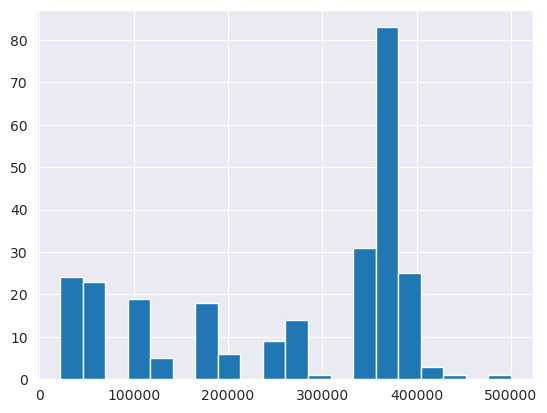

'\nprocess_partition(\'A\', X_train.drop([\'cc_num\', \'merchant\', \'category\', \'job\'], axis=1))\n#process_partition(\'A\', val_df.sample(100).drop([\'cc_num\', \'merchant\', \'category\', \'job\', \'is_fraud\'], axis=1))\nprocess_partition(\'A\', poisoned_df.drop([\'cc_num\', \'merchant\', \'category\', \'job\', \'is_fraud\'], axis=1))\n\n# Step 7: Compute divergence between the two latest GMMs\ntimestamps = get_timestamps(\'A\')\nif len(timestamps) >= 2:\n    timestamp_current, timestamp_previous = timestamps[0], timestamps[1]\n    gmm_current = load_gmm_by_timestamp(\'A\', timestamp_current)\n    gmm_previous = load_gmm_by_timestamp(\'A\', timestamp_previous)\n    if gmm_current and gmm_previous:\n        cs_div = cauchy_schwarz_divergence(gmm_current, gmm_previous)\n        print(f"Cauchy-Schwarz Divergence between GMMs at {timestamp_current} and {timestamp_previous}: {cs_div}")\nelse:\n    print("Not enough timestamps to compute divergence.")\n\n# Step 8: Load and display raw 

In [10]:
import pandas as pd
import numpy as np
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from pymongo import MongoClient
from datetime import datetime
from numpy.linalg import slogdet, inv, solve
from scipy.special import logsumexp

def get_db(partition_name):
    client = MongoClient('mongodb://localhost:27017/')
    db_name = f"gmm_sketch_{partition_name}"
    db = client[db_name]
    return db

def insert_raw_data(partition_name, data_frame):
    db = get_db(partition_name)
    current_time = datetime.now()
    tmp_df = data_frame.copy()
    tmp_df.insert(0, 'timestamp', current_time)
    cols = ['timestamp']
    for n in range(len(data_frame.columns)):
        cols.append(f'x{n}')
    tmp_df.columns = cols
    records = tmp_df.to_dict('records')
    db['raw_data'].insert_many(records)

def store_parameters_with_timestamp(params, max_gmm_entries):
    db = get_db(params['partition'])
    current_time = datetime.now()
    document = {
        'timestamp': current_time,
        'weights': params['weights'],
        'means': params['means'],
        'covariances': params['covariances']
    }
    db['gmm_sketch'].insert_one(document)

    # Enforce the limit of max_gmm_entries
    collection = db['gmm_sketch']
    count = collection.count_documents({})
    if count > max_gmm_entries:
        # Delete the oldest documents
        excess = count - max_gmm_entries
        oldest_docs = collection.find().sort('timestamp', 1).limit(excess)
        oldest_ids = [doc['_id'] for doc in oldest_docs]
        collection.delete_many({'_id': {'$in': oldest_ids}})

def process_partition(partition_name, partition_data, max_gmm_entries=7):
    create_raw_data_table(partition_name, len(partition_data.columns))
    insert_raw_data(partition_name, partition_data)
    X = load_raw_data(partition_name).drop(['timestamp'], axis=1).values
    #print("X: ", X, " DATA: ", partition_data)
    gmm = BayesianGaussianMixture(n_components=40, covariance_type='full', random_state=42)
    gmm.fit(partition_data.values)
    params = {
        'partition': partition_name,
        'weights': gmm.weights_.tolist(),
        'means': gmm.means_.tolist(),
        'covariances': gmm.covariances_.tolist()
    }
    store_parameters_with_timestamp(params, max_gmm_entries)
    print(f"GMM for partition {partition_name} has been processed and stored.")

    # Retrieve the last N GMMs excluding the most recent one
    db = get_db(partition_name)
    collection = db['gmm_sketch']

    # Get all timestamps in descending order
    cursor = collection.find({}, {'timestamp': 1}).sort('timestamp', -1)
    timestamps = [doc['timestamp'] for doc in cursor]

    if len(timestamps) > 1:
        # Exclude the most recent one (the one we just added)
        previous_timestamps = timestamps[1:max_gmm_entries+1]
        divergences = []
        for ts in previous_timestamps:
            previous_gmm = load_gmm_by_timestamp(partition_name, ts)
            divergence = cauchy_schwarz_divergence(gmm, previous_gmm)
            if divergence is not None:
                divergences.append(divergence)
        if divergences:
            average_divergence = sum(divergences) / len(divergences)
            print(f"Average Cauchy-Schwarz divergence with the last {len(divergences)} GMMs: {divergences}")
            return average_divergence
        else:
            print("No valid divergences computed.")
            return None
    else:
        print("Not enough GMMs to compute divergence.")
        return None

def load_raw_data(partition_name):
    db = get_db(partition_name)
    collection = db['raw_data']
    cursor = collection.find()
    df = pd.DataFrame(list(cursor))
    if '_id' in df.columns:
        df = df.drop('_id', axis=1)
    return df

def get_timestamps(partition_name):
    db = get_db(partition_name)
    collection = db['gmm_sketch']
    if 'gmm_sketch' not in db.list_collection_names():
        return None
    cursor = collection.find({}, {'timestamp': 1, '_id': 0}).sort('timestamp', -1)
    timestamps = [doc['timestamp'] for doc in cursor]
    return timestamps

def load_gmm_by_timestamp(partition_name, timestamp):
    db = get_db(partition_name)
    collection = db['gmm_sketch']
    doc = collection.find_one({'timestamp': timestamp})
    if doc:
        weights = doc['weights']
        means = doc['means']
        covariances = doc['covariances']
        gmm = reconstruct_gmm(weights, means, covariances)
        return gmm
    else:
        print(f"No GMM parameters found for partition {partition_name} at timestamp {timestamp}.")
        return None

def reconstruct_gmm(weights, means, covariances):
    gmm = GaussianMixture(n_components=len(weights), covariance_type='full')
    gmm.weights_ = np.array(weights)
    gmm.means_ = np.array(means)
    gmm.covariances_ = np.array(covariances)
    #gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))
    return gmm

'''def cauchy_schwarz_divergence(gmm_p, gmm_q):
    weights_p = gmm_p.weights_
    means_p = gmm_p.means_
    covs_p = gmm_p.covariances_

    weights_q = gmm_q.weights_
    means_q = gmm_q.means_
    covs_q = gmm_q.covariances_

    K_p = len(weights_p)
    K_q = len(weights_q)
    d = means_p.shape[1]
    coeff = (2 * np.pi) ** (d / 2)

    def compute_I(weights_a, means_a, covs_a, weights_b, means_b, covs_b):
        I = 0.0
        for i in range(len(weights_a)):
            for j in range(len(weights_b)):
                w_i = weights_a[i]
                w_j = weights_b[j]
                mu_i = means_a[i]
                mu_j = means_b[j]
                Sigma_i = covs_a[i]
                Sigma_j = covs_b[j]
                Sigma_ij = Sigma_i + Sigma_j
                try:
                    sign, logdet_Sigma_ij = slogdet(Sigma_ij)
                    if sign <= 0:
                        raise np.linalg.LinAlgError("Covariance matrix is not positive definite.")
                    diff = mu_i - mu_j
                    exponent = -0.5 * diff.T @ inv(Sigma_ij) @ diff
                    I_ij = w_i * w_j * np.exp(exponent) / (coeff * np.exp(0.5 * logdet_Sigma_ij))
                    I += I_ij
                except np.linalg.LinAlgError as e:
                    print(f"Error computing I for components {i}, {j}: {e}")
                    return None
        return I

    I_pq = compute_I(weights_p, means_p, covs_p, weights_q, means_q, covs_q)
    I_pp = compute_I(weights_p, means_p, covs_p, weights_p, means_p, covs_p)
    I_qq = compute_I(weights_q, means_q, covs_q, weights_q, means_q, covs_q)

    if None in (I_pq, I_pp, I_qq) or I_pq == 0 or I_pp == 0 or I_qq == 0:
        print("Error: Invalid values encountered in divergence computation.")
        return None

    cs_divergence = -np.log((I_pq ** 2) / (I_pp * I_qq))
    return cs_divergence'''

def cauchy_schwarz_divergence(gmm_p, gmm_q):
    """
    Compute the Cauchy-Schwarz divergence between two GMMs using logarithmic computations.

    Parameters:
    - gmm_p: dict with keys 'weights', 'means', 'covariances' for the first GMM.
    - gmm_q: dict with keys 'weights', 'means', 'covariances' for the second GMM.

    Returns:
    - cs_divergence: The Cauchy-Schwarz divergence between GMM p and q.
    """

    weights_p = gmm_p.weights_
    means_p = gmm_p.means_
    covs_p = gmm_p.covariances_

    weights_q = gmm_q.weights_
    means_q = gmm_q.means_
    covs_q = gmm_q.covariances_

    K_p = len(weights_p)  # Number of components in GMM p
    K_q = len(weights_q)  # Number of components in GMM q
    d = means_p.shape[1]  # Dimensionality

    # Precompute constants
    log_coeff = -0.5 * d * np.log(2 * np.pi)

    # Compute log I_pq
    log_I_pq_terms = []
    for i in range(K_p):
        for j in range(K_q):
            log_w_i = np.log(weights_p[i])
            log_w_j = np.log(weights_q[j])
            mu_i = means_p[i]
            mu_j = means_q[j]
            Sigma_i = covs_p[i]
            Sigma_j = covs_q[j]

            Sigma_ij = Sigma_i + Sigma_j
            try:
                # Compute log-determinant and inverse
                sign, logdet_Sigma_ij = slogdet(Sigma_ij)
                if sign <= 0:
                    raise np.linalg.LinAlgError("Covariance matrix is not positive definite.")
                diff = mu_i - mu_j
                # Solve linear system instead of inverting
                exponent = -0.5 * diff.T @ solve(Sigma_ij, diff)
                log_I_ij = log_w_i + log_w_j + log_coeff - 0.5 * logdet_Sigma_ij + exponent
                log_I_pq_terms.append(log_I_ij)
            except np.linalg.LinAlgError as e:
                print(f"Error computing log_I_pq for components {i}, {j}: {e}")
                return None

    log_I_pq = logsumexp(log_I_pq_terms)

    # Compute log I_pp
    log_I_pp_terms = []
    for i in range(K_p):
        for j in range(K_p):
            log_w_i = np.log(weights_p[i])
            log_w_j = np.log(weights_p[j])
            mu_i = means_p[i]
            mu_j = means_p[j]
            Sigma_i = covs_p[i]
            Sigma_j = covs_p[j]

            Sigma_ij = Sigma_i + Sigma_j
            try:
                sign, logdet_Sigma_ij = slogdet(Sigma_ij)
                if sign <= 0:
                    raise np.linalg.LinAlgError("Covariance matrix is not positive definite.")
                diff = mu_i - mu_j
                exponent = -0.5 * diff.T @ solve(Sigma_ij, diff)
                log_I_ij = log_w_i + log_w_j + log_coeff - 0.5 * logdet_Sigma_ij + exponent
                log_I_pp_terms.append(log_I_ij)
            except np.linalg.LinAlgError as e:
                print(f"Error computing log_I_pp for components {i}, {j}: {e}")
                return None

    log_I_pp = logsumexp(log_I_pp_terms)

    # Compute log I_qq
    log_I_qq_terms = []
    for i in range(K_q):
        for j in range(K_q):
            log_w_i = np.log(weights_q[i])
            log_w_j = np.log(weights_q[j])
            mu_i = means_q[i]
            mu_j = means_q[j]
            Sigma_i = covs_q[i]
            Sigma_j = covs_q[j]

            Sigma_ij = Sigma_i + Sigma_j
            try:
                sign, logdet_Sigma_ij = slogdet(Sigma_ij)
                if sign <= 0:
                    raise np.linalg.LinAlgError("Covariance matrix is not positive definite.")
                diff = mu_i - mu_j
                exponent = -0.5 * diff.T @ solve(Sigma_ij, diff)
                log_I_ij = log_w_i + log_w_j + log_coeff - 0.5 * logdet_Sigma_ij + exponent
                log_I_qq_terms.append(log_I_ij)
            except np.linalg.LinAlgError as e:
                print(f"Error computing log_I_qq for components {i}, {j}: {e}")
                return None

    log_I_qq = logsumexp(log_I_qq_terms)

    # Compute the Cauchy-Schwarz divergence
    cs_divergence = - (2 * log_I_pq - (log_I_pp + log_I_qq))

    return cs_divergence

def process_data_by_day(df, max_gmm_entries=7):
    # Convert 'unix_time' to datetime
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')
    df['date'] = df['datetime'].dt.date
    df['hour'] = df['datetime'].dt.hour

    div_vals = []

    # Group by date
    dates = df['date'].unique()
    for date in sorted(dates):
        print(f"\nProcessing data for date: {date}")
        day_data = df[df['date'] == date]
        # Process each hour
        for hour in range(24):
            partition_name = f"hour_{hour}"
            hour_data = day_data[day_data['hour'] == hour]
            if not hour_data.empty:
                # Drop unnecessary columns before processing
                partition_data = hour_data.drop(['datetime', 'date', 'hour'], axis=1)
                print(f"\nProcessing partition: {partition_name} with {len(partition_data)} records.")
                average_divergence = process_partition(partition_name, partition_data, max_gmm_entries)
                if average_divergence is not None:
                    print(f"Average Cauchy-Schwarz divergence for partition {partition_name} on {date}: {average_divergence}")
                    div_vals.append(average_divergence)
            else:
                print(f"No data for partition {partition_name} on {date}.")

    print("\nData processing complete.")
    return div_vals

div_vals = process_data_by_day(val_df)

plt.hist(div_vals, bins=20)
plt.show()

'''
process_partition('A', X_train.drop(['cc_num', 'merchant', 'category', 'job'], axis=1))
#process_partition('A', val_df.sample(100).drop(['cc_num', 'merchant', 'category', 'job', 'is_fraud'], axis=1))
process_partition('A', poisoned_df.drop(['cc_num', 'merchant', 'category', 'job', 'is_fraud'], axis=1))

# Step 7: Compute divergence between the two latest GMMs
timestamps = get_timestamps('A')
if len(timestamps) >= 2:
    timestamp_current, timestamp_previous = timestamps[0], timestamps[1]
    gmm_current = load_gmm_by_timestamp('A', timestamp_current)
    gmm_previous = load_gmm_by_timestamp('A', timestamp_previous)
    if gmm_current and gmm_previous:
        cs_div = cauchy_schwarz_divergence(gmm_current, gmm_previous)
        print(f"Cauchy-Schwarz Divergence between GMMs at {timestamp_current} and {timestamp_previous}: {cs_div}")
else:
    print("Not enough timestamps to compute divergence.")

# Step 8: Load and display raw data (optional)
df_raw = load_raw_data('A')
print(f"Total raw data points in partition A: {len(df_raw)}")
'''